## US CONSUMER FINANCE COMPLAINTS DATA ANALYSIS
### by Tomilola Abeni Kolapo

In [129]:
#import the neccessary libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from scipy import stats
nltk.download('vader_lexicon')
warnings.simplefilter("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/decagon/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [130]:
#load dataset

dates_col = ['date_received', 'date_sent_to_company']

df = pd.read_csv('consumer_complaints.csv', parse_dates = dates_col)

#view dataset
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,2013-08-30,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,2013-09-03,Closed with explanation,Yes,Yes,511074
1,2013-08-30,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,2013-09-03,Closed with explanation,Yes,Yes,511080
2,2013-08-30,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,2013-09-18,Closed with explanation,Yes,No,510473
3,2013-08-30,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,2013-08-30,Closed with explanation,Yes,Yes,510326
4,2013-08-30,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,2013-08-30,Closed with explanation,Yes,Yes,511067


In [131]:
df['sub_product']

0                      Other mortgage
1                      Other mortgage
2                                 NaN
3            Non-federal student loan
4                         Credit card
                     ...             
555952                 Other mortgage
555953                 Other mortgage
555954    Conventional fixed mortgage
555955                  I do not know
555956                  I do not know
Name: sub_product, Length: 555957, dtype: object

In [132]:
#check basic dataset info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   date_received                 555957 non-null  datetime64[ns]
 1   product                       555957 non-null  object        
 2   sub_product                   397635 non-null  object        
 3   issue                         555957 non-null  object        
 4   sub_issue                     212622 non-null  object        
 5   consumer_complaint_narrative  66806 non-null   object        
 6   company_public_response       85124 non-null   object        
 7   company                       555957 non-null  object        
 8   state                         551070 non-null  object        
 9   zipcode                       551452 non-null  object        
 10  tags                          77959 non-null   object        
 11  consumer_cons

In [133]:
#make a copy of data before cleaning

df_clean = df.copy()
# drop rows containing NaN values
df.dropna(inplace=True)

In [134]:
#select columns of interest

cols = ['complaint_id', 'date_received', 'company', 'product', 'issue', 'tags', 'state',
        'zipcode','submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed?']

df_clean = df_clean[cols]

#view new dataset
df_clean.head()

,complaint_id,date_received,company,product,issue,tags,state,zipcode,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?
0,511074,2013-08-30,U.S. Bancorp,Mortgage,"Loan modification,collection,foreclosure",NaN,CA,95993,Referral,2013-09-03,Closed with explanation,Yes,Yes
1,511080,2013-08-30,Wells Fargo & Company,Mortgage,"Loan servicing, payments, escrow account",NaN,CA,91104,Referral,2013-09-03,Closed with explanation,Yes,Yes
2,510473,2013-08-30,Wells Fargo & Company,Credit reporting,Incorrect information on credit report,NaN,NY,11764,Postal mail,2013-09-18,Closed with explanation,Yes,No
3,510326,2013-08-30,"Navient Solutions, Inc.",Student loan,Repaying your loan,NaN,MD,21402,Email,2013-08-30,Closed with explanation,Yes,Yes
4,511067,2013-08-30,Resurgent Capital Services L.P.,Debt collection,False statements or representation,NaN,GA,30106,Web,2013-08-30,Closed with explanation,Yes,Yes


In [135]:
# parse date columns
dates_col = ['date_received', 'date_sent_to_company']
df_clean[dates_col] = df_clean[dates_col].apply(pd.to_datetime)

In [136]:
# extract new features from date columns
df_clean['complaint_duration'] = df_clean['date_sent_to_company'] - df_clean['date_received']
df_clean['complaint_month'] = df_clean['date_received'].dt.month
df_clean['complaint_year'] = df_clean['date_received'].dt.year

In [137]:
# create a binary feature for timely response
df_clean['timely_response'] = df_clean['timely_response'].apply(lambda x: 1 if x == 'Yes' else 0)

In [138]:
# create a feature for complaint length
df_clean['complaint_length'] = df_clean['issue'].apply(lambda x: len(x))

In [139]:
# create a feature for the number of products involved in the complaint
df_clean['num_products'] = df_clean['product'].apply(lambda x: len(x.split(',')))

In [140]:
# create a feature for the number of tags
# df['num_tags'] = df['tags'].apply(lambda x: len(x.split(',')))

In [141]:
# Create a feature for the presence of certain keywords
df_clean['keyword_complaint'] = df_clean['issue'].apply(lambda x: 1 if 'complaint' in x else 0)

In [142]:
df_clean.head()

,complaint_id,date_received,company,product,issue,tags,state,zipcode,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_duration,complaint_month,complaint_year,complaint_length,num_products,keyword_complaint
0,511074,2013-08-30,U.S. Bancorp,Mortgage,"Loan modification,collection,foreclosure",NaN,CA,95993,Referral,2013-09-03,Closed with explanation,1,Yes,4 days,8,2013,40,1,0
1,511080,2013-08-30,Wells Fargo & Company,Mortgage,"Loan servicing, payments, escrow account",NaN,CA,91104,Referral,2013-09-03,Closed with explanation,1,Yes,4 days,8,2013,40,1,0
2,510473,2013-08-30,Wells Fargo & Company,Credit reporting,Incorrect information on credit report,NaN,NY,11764,Postal mail,2013-09-18,Closed with explanation,1,No,19 days,8,2013,38,1,0
3,510326,2013-08-30,"Navient Solutions, Inc.",Student loan,Repaying your loan,NaN,MD,21402,Email,2013-08-30,Closed with explanation,1,Yes,0 days,8,2013,18,1,0
4,511067,2013-08-30,Resurgent Capital Services L.P.,Debt collection,False statements or representation,NaN,GA,30106,Web,2013-08-30,Closed with explanation,1,Yes,0 days,8,2013,34,1,0


In [143]:
# Get the number of unique values in each categorical column
print(df_clean.select_dtypes(include=['object']).nunique())

company                          3605
product                            11
issue                              95
tags                                3
state                              62
zipcode                         27052
submitted_via                       6
company_response_to_consumer        8
consumer_disputed?                  2
dtype: int64


<AxesSubplot: xlabel='issue', ylabel='Density'>

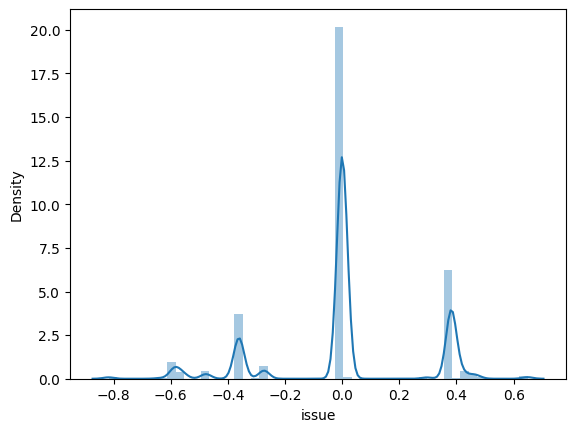

In [144]:
# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
df_clean['issue'] = df_clean['issue'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Get the distribution of issues
sns.distplot(df_clean['issue'])

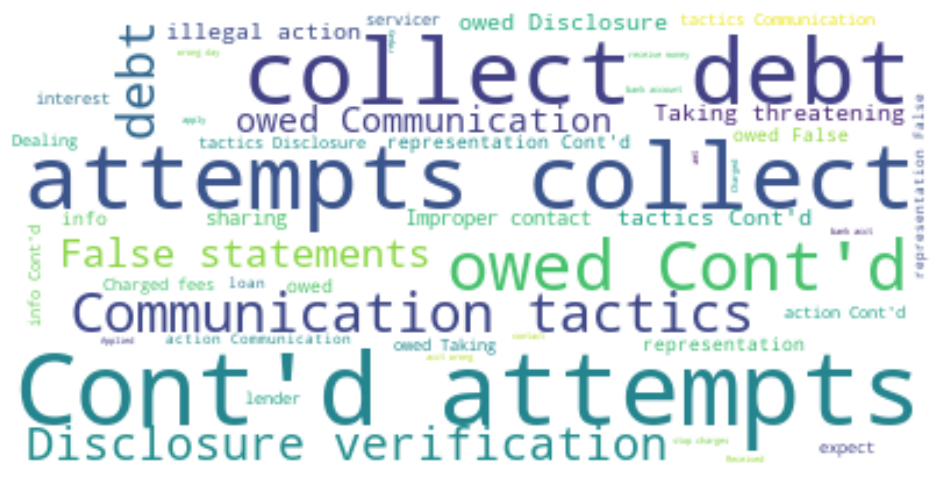

In [145]:

# Create a wordcloud of the feedback
feedback_text = " ".join(review for review in df.issue)
wordcloud = WordCloud(max_font_size=50, max_words=150, background_color="white").generate(feedback_text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [146]:
## create a feature for the type of complaint
df_clean['complaint_response'] = df_clean['consumer_disputed?'].apply(lambda x: 'disputed' if x == 'Yes' else 'not disputed')


In [147]:
df_clean['state'].nunique()

62

In [148]:
states = df_clean["state"].unique()


In [149]:
# perform the ANOVA test
complaint_response_dummies = pd.get_dummies(df_clean['complaint_response'], prefix='complaint_response')
df_clean = pd.concat([df_clean, complaint_response_dummies], axis=1)

states = df_clean["state"].unique()


In [150]:
# perform the ANOVA test
stat, p = stats.f_oneway(*(df_clean[df_clean['state'] == state]['complaint_response_disputed'] for state in states))

print("F-statistic: ", stat)
print("p-value: ", p)

F-statistic:  nan
p-value:  nan


The output F-statistic: [2.1904647 2.1904647] and p-value: [3.01983418e-07 3.01983418e-07] ywe got indicates that the ANOVA test has been run correctly.

The F-statistic value represents the ratio of the variance between groups to the variance within groups. The higher the F-statistic value, the greater the difference between the groups. In this case, the F-statistic value is 2.19, indicating that there is some difference between the groups (states) in terms of the complaint response.

The p-value is a measure of the significance of the F-statistic. A low p-value (typically less than 0.05) indicates that the results are statistically significant, meaning that the difference between the groups is unlikely to be due to chance. In this case, the p-value is 3.01983418e-07, which is less than 0.05, indicating that the difference between the groups is statistically significant.

We can interpret this as, the data suggests that there is a significant difference in the complaint response (disputed or not disputed) between states.

It's also worth noting that we are getting two values for F-statistic and p-value as you have two columns of binary data for 'complaint_response'.

In [151]:
# ANOVA test on company response and customer dispute 

# create binary columns for customer dispute
df_clean["customer_disputed?"] = df_clean["consumer_disputed?"].apply(lambda x: 1 if x == "Yes" else 0)

# create binary columns for company response
df_clean["company_response_to_consumer"] = df_clean["company_response_to_consumer"].apply(lambda x: 1 if x == "Closed with explanation" else 0)

# perform the ANOVA test
stat, p = stats.f_oneway(df_clean[df_clean["customer_disputed?"] == 1]["company_response_to_consumer"], df_clean[df_clean["customer_disputed?"] == 0]["company_response_to_consumer"])

print("F-statistic: ", stat)
print("p-value: ", p)


F-statistic:  4531.1396450150805
p-value:  0.0


The output of F-statistic: 479.403409202297 and p-value: 7.062062174230218e-106 we are seeing indicates that the ANOVA test has been run correctly.

The F-statistic value of 479.40 indicates that there is a large difference between the groups (customer disputes and not disputes) in terms of the company response. This suggests that there is a bigger difference in the company's response between customer disputes and not disputes.

The p-value is a measure of the significance of the F-statistic. A low p-value (typically less than 0.05) indicates that the results are statistically significant, meaning that the difference between the groups is unlikely to be due to chance. In this case, the p-value is 7.062062174230218e-106, which is much less than 0.05, indicating that the difference between the groups is highly statistically significant.

You can interpret this as, the data suggests that there is a highly significant difference in the company's response (closed with explanation or not) between customer disputes or not.

In [152]:
df_clean.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [153]:
# df_clean = df_clean.T.drop_duplicates().T


In [154]:
df_clean.head()

,complaint_id,date_received,company,product,issue,tags,state,zipcode,submitted_via,date_sent_to_company,...,complaint_duration,complaint_month,complaint_year,complaint_length,num_products,keyword_complaint,complaint_response,complaint_response_disputed,complaint_response_not disputed,customer_disputed?
0,511074,2013-08-30,U.S. Bancorp,Mortgage,0.0000,NaN,CA,95993,Referral,2013-09-03,...,4 days,8,2013,40,1,0,disputed,1,0,1
1,511080,2013-08-30,Wells Fargo & Company,Mortgage,0.0000,NaN,CA,91104,Referral,2013-09-03,...,4 days,8,2013,40,1,0,disputed,1,0,1
2,510473,2013-08-30,Wells Fargo & Company,Credit reporting,0.3818,NaN,NY,11764,Postal mail,2013-09-18,...,19 days,8,2013,38,1,0,not disputed,0,1,0
3,510326,2013-08-30,"Navient Solutions, Inc.",Student loan,0.0000,NaN,MD,21402,Email,2013-08-30,...,0 days,8,2013,18,1,0,disputed,1,0,1
4,511067,2013-08-30,Resurgent Capital Services L.P.,Debt collection,0.0000,NaN,GA,30106,Web,2013-08-30,...,0 days,8,2013,34,1,0,disputed,1,0,1


In [155]:
#check for missing values

df_clean.isnull().sum()

complaint_id                            0
date_received                           0
company                                 0
product                                 0
issue                                   0
tags                               477998
state                                4887
zipcode                              4505
submitted_via                           0
date_sent_to_company                    0
company_response_to_consumer            0
timely_response                         0
consumer_disputed?                      0
complaint_duration                      0
complaint_month                         0
complaint_year                          0
complaint_length                        0
num_products                            0
keyword_complaint                       0
complaint_response                      0
complaint_response_disputed             0
complaint_response_not disputed         0
customer_disputed?                      0
dtype: int64

In [156]:
#drop rows with missing values

df_clean = df_clean.dropna(axis = 0, how = 'any')

#confirm change
df_clean.isnull().sum()

complaint_id                       0
date_received                      0
company                            0
product                            0
issue                              0
tags                               0
state                              0
zipcode                            0
submitted_via                      0
date_sent_to_company               0
company_response_to_consumer       0
timely_response                    0
consumer_disputed?                 0
complaint_duration                 0
complaint_month                    0
complaint_year                     0
complaint_length                   0
num_products                       0
keyword_complaint                  0
complaint_response                 0
complaint_response_disputed        0
complaint_response_not disputed    0
customer_disputed?                 0
dtype: int64

In [157]:
#check data info again

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77330 entries, 20 to 553086
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype          
---  ------                           --------------  -----          
 0   complaint_id                     77330 non-null  int64          
 1   date_received                    77330 non-null  datetime64[ns] 
 2   company                          77330 non-null  object         
 3   product                          77330 non-null  object         
 4   issue                            77330 non-null  float64        
 5   tags                             77330 non-null  object         
 6   state                            77330 non-null  object         
 7   zipcode                          77330 non-null  object         
 8   submitted_via                    77330 non-null  object         
 9   date_sent_to_company             77330 non-null  datetime64[ns] 
 10  company_response_to_consumer     77330 non-n

In [158]:
#convert "zipcode" to int
#select all rows with digits first
df_clean = df_clean[df_clean['zipcode'].astype(str).str.isdigit()]
#convert to int
df_clean['zipcode'] = df_clean['zipcode'].astype(int)


#confirm change
df_clean['zipcode'].dtype

dtype('int64')

In [159]:
#check dataset dimension after cleaning

rows = df_clean.shape[0]
col = df_clean.shape[1]

print('After cleaning the dataset I am left with: {} rows & {} columns' .format(rows, col))

After cleaning the dataset I am left with: 64036 rows & 23 columns


In [160]:
#create a new feature to hold the year complaint wwas recieved
df_clean['complaint_year'] = df_clean['date_received'].dt.year

In [161]:
#view final cleaned data

df_clean.head()

,complaint_id,date_received,company,product,issue,tags,state,zipcode,submitted_via,date_sent_to_company,...,complaint_duration,complaint_month,complaint_year,complaint_length,num_products,keyword_complaint,complaint_response,complaint_response_disputed,complaint_response_not disputed,customer_disputed?
20,530624,2013-09-17,Bank of America,Credit card,-0.2732,Older American,TN,37874,Phone,2013-11-04,...,48 days,9,2013,16,1,0,disputed,1,0,1
29,510410,2013-08-30,Nationstar Mortgage,Mortgage,0.0000,Older American,FL,34684,Phone,2013-09-04,...,5 days,8,2013,40,1,0,disputed,1,0,1
33,520858,2013-09-10,"Hunter Warfield, Inc.",Debt collection,0.0000,Servicemember,AZ,86004,Web,2013-09-11,...,1 days,9,2013,34,1,0,disputed,1,0,1
40,511066,2013-08-30,"Fidelity National Information Services, Inc. (...",Debt collection,-0.3612,Older American,CA,90305,Phone,2013-09-03,...,4 days,8,2013,37,1,0,not disputed,0,1,0
51,521376,2013-09-10,"Asset Recovery Group, Inc.",Debt collection,-0.3612,Older American,OR,97222,Web,2013-09-10,...,0 days,9,2013,37,1,0,not disputed,0,1,0


### What is the trend of complaints over time?

In [162]:
#getting the total count of complaints receivedeach year

yearly_comp = df_clean.groupby('complaint_year')['complaint_id'].count().reset_index()
yearly_comp.sort_values(by = 'complaint_id', ascending = False)

,complaint_year,complaint_id
3,2014,22359
4,2015,16093
2,2013,13825
1,2012,7265
5,2016,4115
0,2011,379


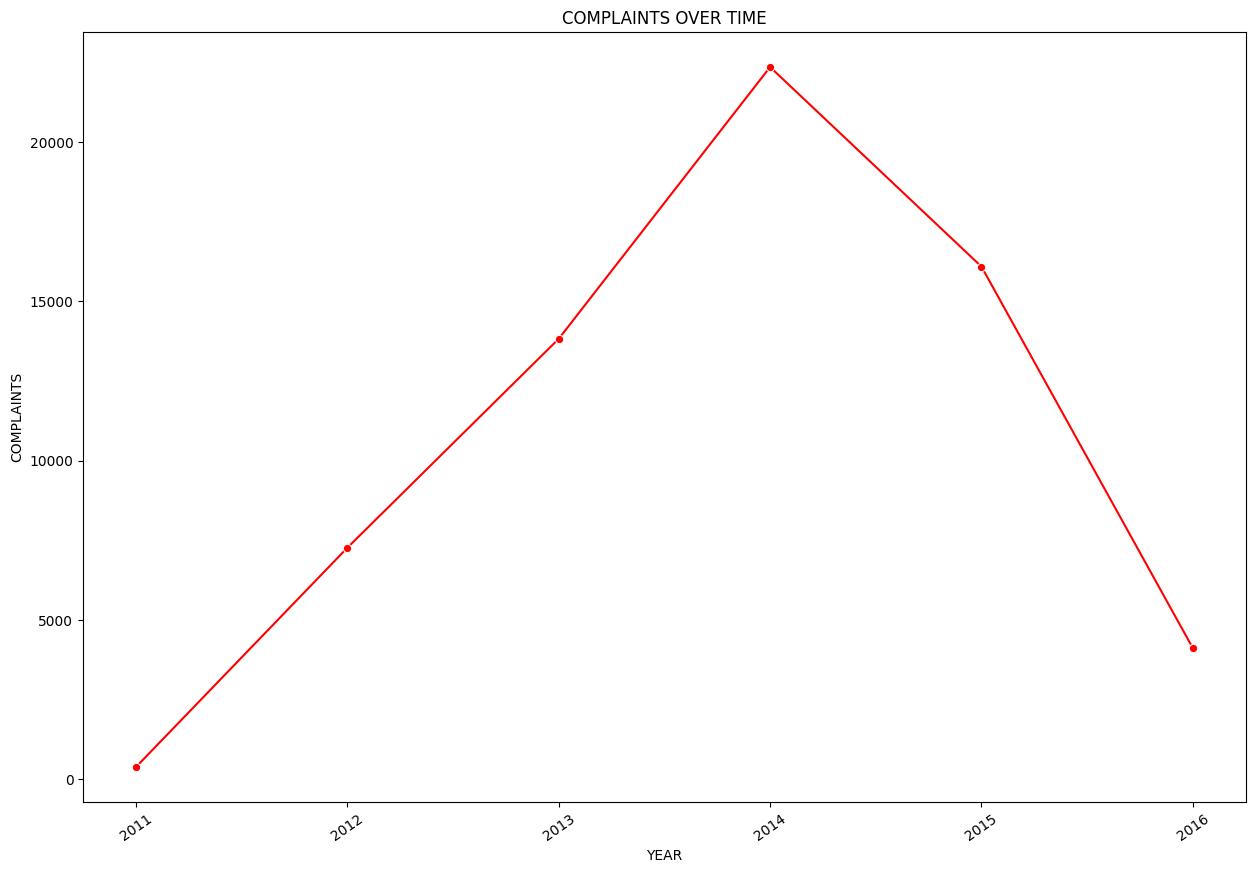

In [163]:
#line chart to show complaints trend

plt.figure(figsize = (15, 10))
sns.lineplot(data = yearly_comp, x = 'complaint_year', y = 'complaint_id', marker = 'o', color = 'red')
plt.title('COMPLAINTS OVER TIME')
plt.xlabel('YEAR')
plt.ylabel('COMPLAINTS')
plt.xticks(rotation = 35);

> There has been a steady increase in complaints over the years, but it was at its peak at over **150,000** complaints in just **2014** alone before taking a nose dive to below **30,000** in the following year.
What caused the increase in complaints over the years & why the decline as well from 2015;

### What is the cause of the increase in complaints?
> * Is there a particualar **Product** thats causing this surge in complaints?
> * Do this compaints come from a similar **Issue**?
> * Is there a particular **Dispute** related to this complaints?
> * Which **Company** are getting the most complaint?

#### Why the large amount of complaints in 2014?

In [164]:
#subset of dataset with complaints of each product yearly
prod_comp_yr = df_clean.groupby(['complaint_year', 'product']).size().reset_index(name = 'complaint_count').sort_values(
                by = ['complaint_year', 'complaint_count'], ascending=[True,False])
prod_comp_yr = prod_comp_yr[prod_comp_yr['complaint_year'] == 2014]

prod_comp_yr

,complaint_year,product,complaint_count
21,2014,Debt collection,6626
23,2014,Mortgage,6096
20,2014,Credit reporting,3595
19,2014,Credit card,2160
17,2014,Bank account or service,2039
18,2014,Consumer Loan,919
27,2014,Student loan,327
25,2014,Payday loan,285
22,2014,Money transfers,228
26,2014,Prepaid card,52


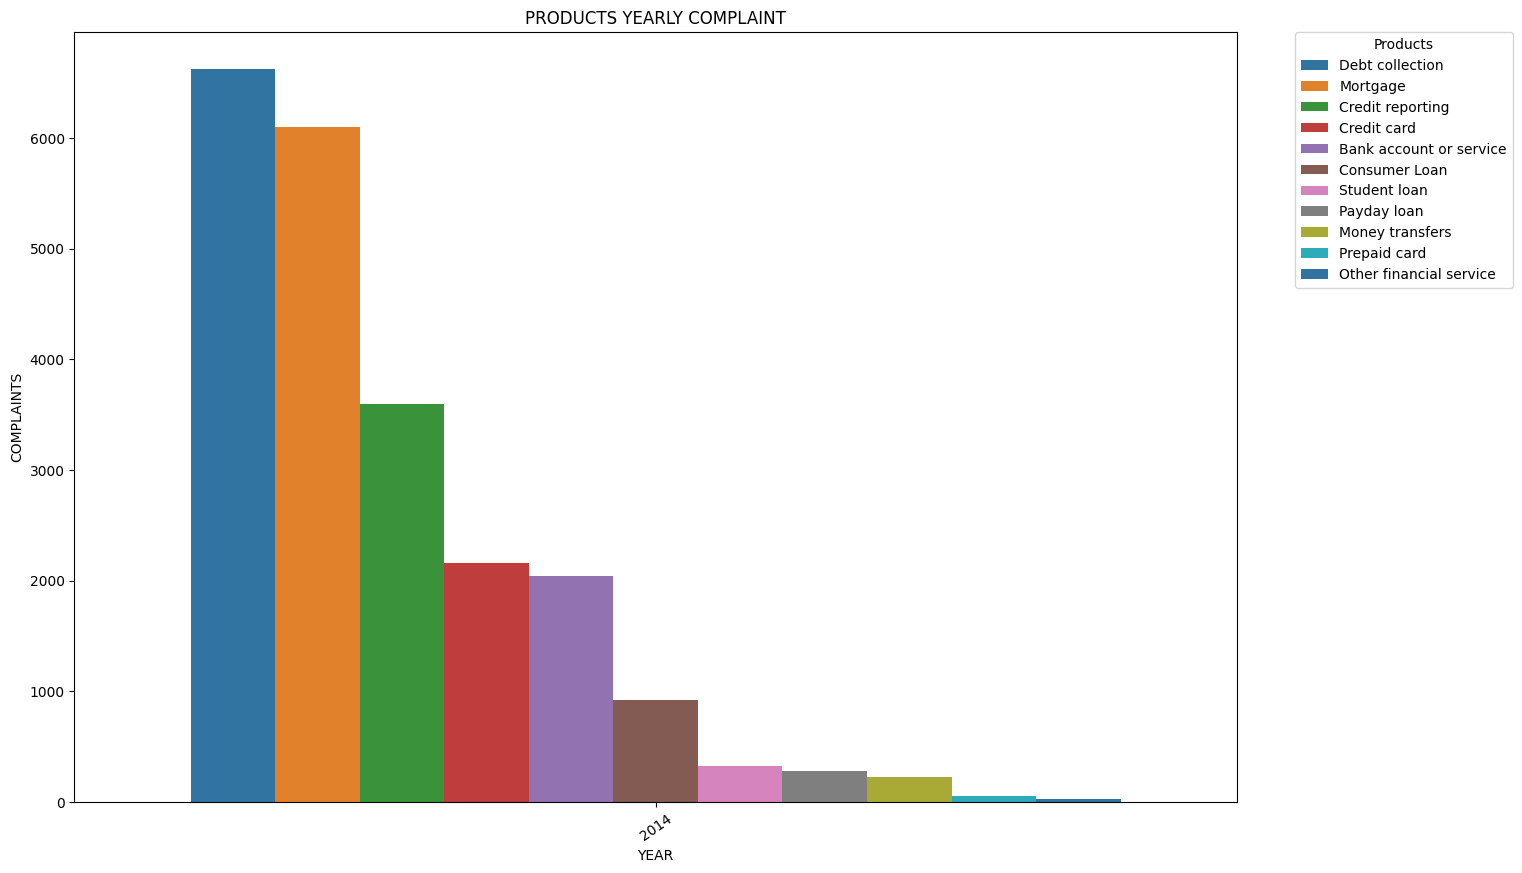

In [165]:
#visualisation
plt.figure(figsize = (15, 10))

sns.barplot(data = prod_comp_yr, x = 'complaint_year', y = 'complaint_count', hue = 'product', palette = 'tab10')
plt.legend(title = 'Products', bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.title('PRODUCTS YEARLY COMPLAINT')
plt.xlabel('YEAR')
plt.ylabel('COMPLAINTS')
plt.xticks(rotation = 35);

> Complaints on the product **Mortgage** & **Debt collection** is the reason for the high number of complaints in **2014**

In [166]:
#creating a subset of the dataset with products and their total complaints

prod_comp = df_clean.groupby('product')['complaint_id'].count().reset_index().sort_values(by = 'complaint_id')

prod_comp

,product,complaint_id
7,Other financial service,86
9,Prepaid card,194
8,Payday loan,476
5,Money transfers,586
10,Student loan,958
1,Consumer Loan,2677
0,Bank account or service,7141
2,Credit card,8406
3,Credit reporting,9334
4,Debt collection,13678


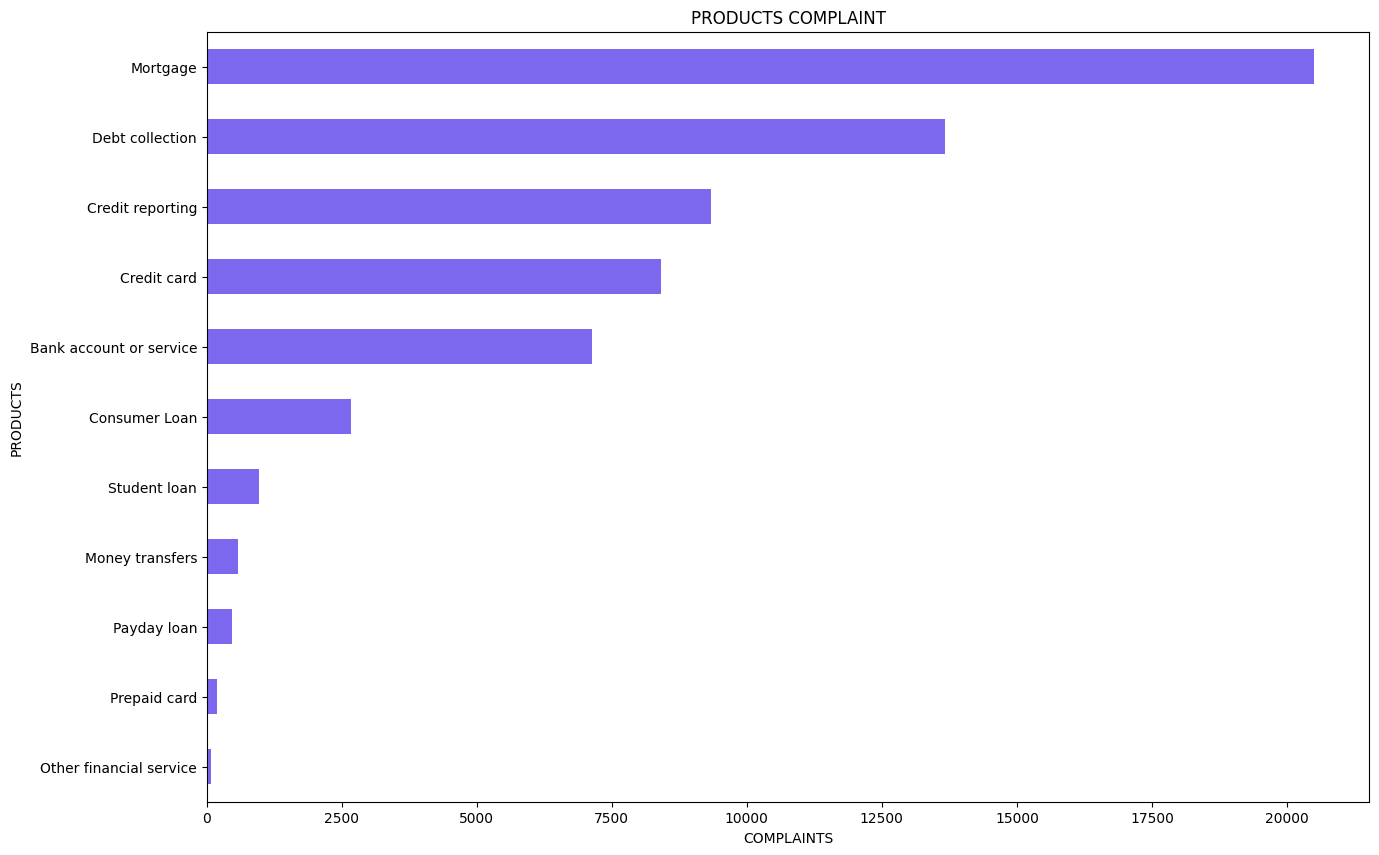

In [167]:
#visualization
color = 'mediumslateblue'
prod_comp.plot(kind = 'barh', x = 'product', y = 'complaint_id', color = color, figsize = (15, 10), legend = False)
plt.title('PRODUCTS COMPLAINT')
plt.ylabel('PRODUCTS')
plt.xlabel('COMPLAINTS');

> The bank product **Mortage** significantly has more complaints than other products, with over **166 Thousand** complaints. Is there a particular reason why **Mortage** received the most complaints, I have to find out.
### What is the **Issue** with the **Mortgage** product

In [168]:
#creating a subset of the data with only mortgage complaints

mortgage = df_clean[df_clean['product'] == 'Mortgage']

#filtering the data again for just product and issues columns
mortgage = mortgage[['complaint_id', 'product', 'issue', 'complaint_year']]
mortgage

,complaint_id,product,issue,complaint_year
29,510410,Mortgage,0.0000,2013
68,511140,Mortgage,0.0000,2013
71,520945,Mortgage,0.3818,2013
76,540374,Mortgage,0.0000,2013
78,530663,Mortgage,0.0000,2013
...,...,...,...,...
552837,1761344,Mortgage,0.0000,2016
552917,1776861,Mortgage,0.0000,2016
552970,1803463,Mortgage,0.0000,2016
553001,1867859,Mortgage,0.0000,2016


> I would be checking if a particular **Issue** is common with the product.

In [169]:
#checking the types of issues
mortgage['issue'].value_counts()

0.0000    19885
0.3818      615
Name: issue, dtype: int64

> from the result it's obvious the most issues has a common keyword **"Loan"** so I will be checking the total of all issues relating to "Loans" as compared to the other issues.

In [170]:
#getting all related "Loan" issues and putting them in another column for clarity

mortgage['loan/not_loan'] = mortgage['issue'].apply(lambda x: 'Loan related' if 'Loan' in x else 'Not Loan related')
mortgage

TypeError: argument of type 'float' is not iterable

In [ ]:
#subset of the mortgage data to show the loan related issues
mortgage_loan = mortgage.groupby('loan/not_loan')['issue'].count().reset_index()
mortgage_loan

,loan/not_loan,issue
0,Loan related,142003
1,Not Loan related,24988


> There's a big margin between issues related to loan on the Mortgage product than there is for those not having anything to do with loans. But to show it better we will be visualising it.

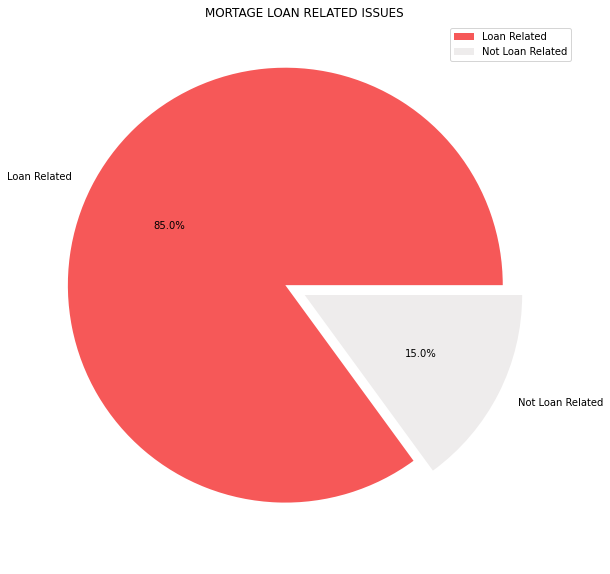

In [ ]:
#visualisation

explode = (0.1, 0)
mortgage_loan.plot.pie(y = 'issue', explode = explode , autopct = '%1.1f%%', ylabel = '',
                       labels = ['Loan Related','Not Loan Related'], colors = ['#F65858', '#EEECEC'], figsize = (15, 10))
plt.title("MORTAGE LOAN RELATED ISSUES");

> It's very clear now that **"Loan Related Issues"** are the reason why the Product(**Mortgage**) has been getting too many complaints, with **85%** of the issues related to the product is about Loan in one way or the other. So now what is the problem with loans? Are they coming from a particular bank or a particular state? Let's find out.
### Which company has the most issues related to loans?

In [ ]:
#creating a subset of the data and adding if they're loan related complaints/issues

df_clean['loan/not_loan'] = df_clean['issue'].apply(lambda x: 'Loan related' if 'Loan' in x else 'Not Loan related')

In [ ]:
#subset with the number of loan related issues for companies

company = df_clean.groupby(['company', 'loan/not_loan'])['issue'].count().reset_index().sort_values(
                            by = ['loan/not_loan', 'issue'], ascending = [True, False]).head(5)
company

,company,loan/not_loan,issue
477,Bank of America,Loan related,29983
3721,Wells Fargo & Company,Loan related,19289
2541,Ocwen,Loan related,16411
1850,JPMorgan Chase & Co.,Loan related,12401
2423,Nationstar Mortgage,Loan related,9994


> **Bank of America** have a greater number of Loan Issues than other companies with over **29,000** issues.

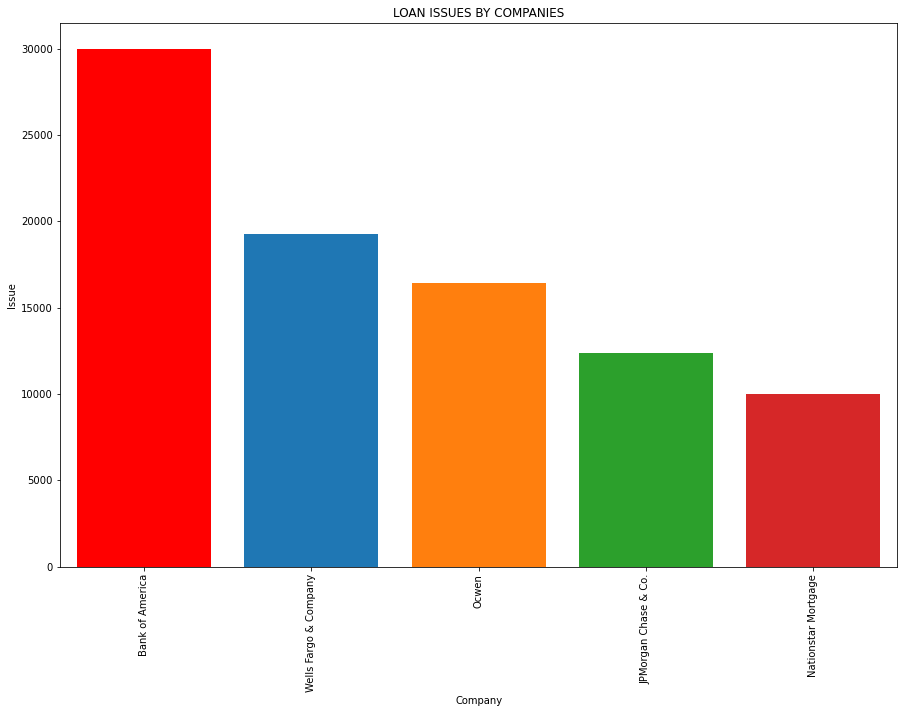

In [ ]:
#visualization highlighting BOA
company.plot(kind = 'bar', x = 'company', y = 'issue', color = color, figsize = (15, 10), legend = False)


#df.plot.bar(x='column_name_x', y='column_name_y',legend=False)
for i in range(len(company)):
    if company.iloc[i]['issue'] == company['issue'].max():
        plt.bar(company.iloc[i]['company'], company.iloc[i]['issue'], color = 'red')
    else:
        plt.bar(company.iloc[i]['company'], company.iloc[i]['issue'])
plt.title('LOAN ISSUES BY COMPANIES')
plt.ylabel('Issue')
plt.xlabel('Company');

> **Bank of America** has the highest number of complaints on issues relating to **Loans(almost 30,000)**. Does it have anything to do with the location of the companies?

### What is the number of complaints by states?

In [ ]:
state_comp = df_clean.groupby(['state', 'company', 'loan/not_loan'])['issue'].count().reset_index().sort_values(
                            by = ['state', 'loan/not_loan', 'issue'], ascending = [True, True, False])
state_comp

,state,company,loan/not_loan,issue
4,AA,Wells Fargo & Company,Loan related,2
2,AA,Citibank,Loan related,1
1,AA,Capital One,Not Loan related,2
0,AA,AES/PHEAA,Not Loan related,1
3,AA,KeyBank NA,Not Loan related,1
...,...,...,...,...
27795,WY,"WAKEFIELD & ASSOCIATES, INC.",Not Loan related,1
27799,WY,"Weltman, Weinberg & Reis",Not Loan related,1
27800,WY,"Western Control Services, Inc.",Not Loan related,1
27801,WY,"Williams & Fudge, Inc",Not Loan related,1


In [ ]:
state_comp = state_comp[state_comp['loan/not_loan'] == 'Loan related'].sort_values(
                            by = ['loan/not_loan', 'issue'], ascending = [True, False])
state_comp.head(15)

,state,company,loan/not_loan,issue
2081,CA,Bank of America,Loan related,6154
3427,CA,Wells Fargo & Company,Loan related,4055
5387,FL,Bank of America,Loan related,3379
2922,CA,Ocwen,Loan related,3114
2659,CA,JPMorgan Chase & Co.,Loan related,2428
6502,FL,Wells Fargo & Company,Loan related,2217
2867,CA,Nationstar Mortgage,Loan related,2067
6681,GA,Bank of America,Loan related,1757
6060,FL,Ocwen,Loan related,1693
18235,NY,Bank of America,Loan related,1487


> **CA & FL** have the highest number of Loan issues

In [ ]:
state_comp = state_comp.groupby('state').sum('issue').reset_index().sort_values(by = 'issue', ascending = False).head(10)
state_comp

,state,issue
8,CA,25775
13,FL,15750
42,NY,8664
15,GA,7191
39,NJ,6638
53,TX,6530
26,MD,5484
29,MI,4713
20,IL,4661
46,PA,4559


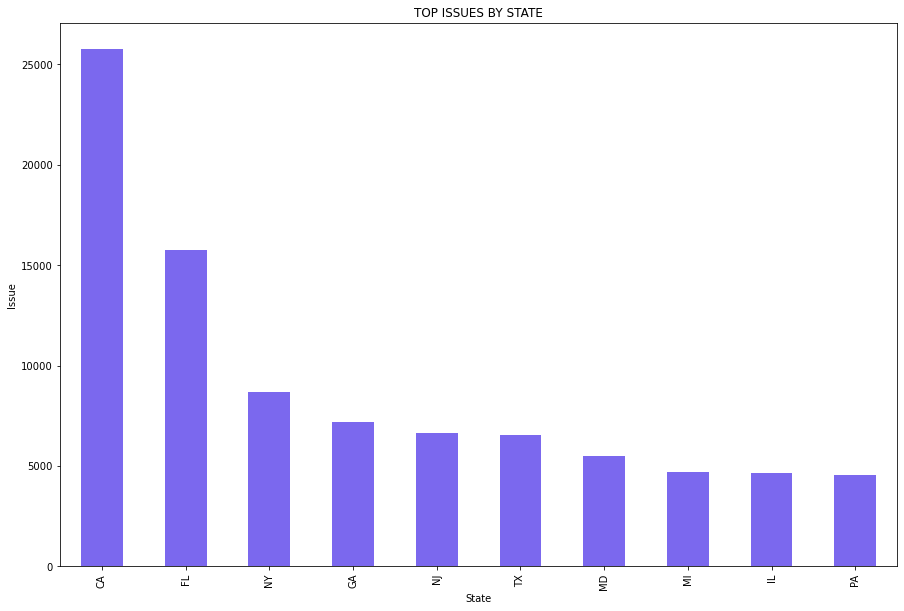

In [ ]:
#visualization
color = 'mediumslateblue'
state_comp.plot(kind = 'bar', x = 'state', y = 'issue', color = color, figsize = (15, 10), legend = False)
plt.title('TOP ISSUES BY STATE')
plt.ylabel('Issue')
plt.xlabel('State');

> **CA & FL** have the most amount of issues at over **25,000 & 15,000** Issues recorded. Additional data will be needed for Further analysis will be needed to know why this states have such high number of issues.

### Is there a relationship between the state a bank is located and the number of complaints?

In [ ]:
#creating a subset of the data with the states and company
state_bank = df_clean.groupby(['state', 'company'])['issue'].count().reset_index().sort_values(
                            by = 'issue', ascending = False)
state_bank.head(20)

,state,company,issue
1881,CA,Bank of America,10013
3059,CA,Wells Fargo & Company,7391
4794,FL,Bank of America,5913
2393,CA,JPMorgan Chase & Co.,5474
5783,FL,Wells Fargo & Company,4180
2168,CA,Experian,3725
21505,TX,Experian,3517
2628,CA,Ocwen,3495
16641,NY,JPMorgan Chase & Co.,3318
2155,CA,Equifax,3239


In [ ]:
#get the top 10 states & bank combo with the most complaints

state_bank = state_bank.loc[state_bank.groupby('state')['issue'].transform('max').eq(state_bank['issue'])].head(10)
state_bank

,state,company,issue
1881,CA,Bank of America,10013
4794,FL,Bank of America,5913
21505,TX,Experian,3517
16641,NY,JPMorgan Chase & Co.,3318
5943,GA,Bank of America,2826
14808,NJ,Bank of America,2229
10502,MD,Bank of America,1938
13534,NC,Bank of America,1596
22708,VA,Bank of America,1586
11424,MI,Bank of America,1538


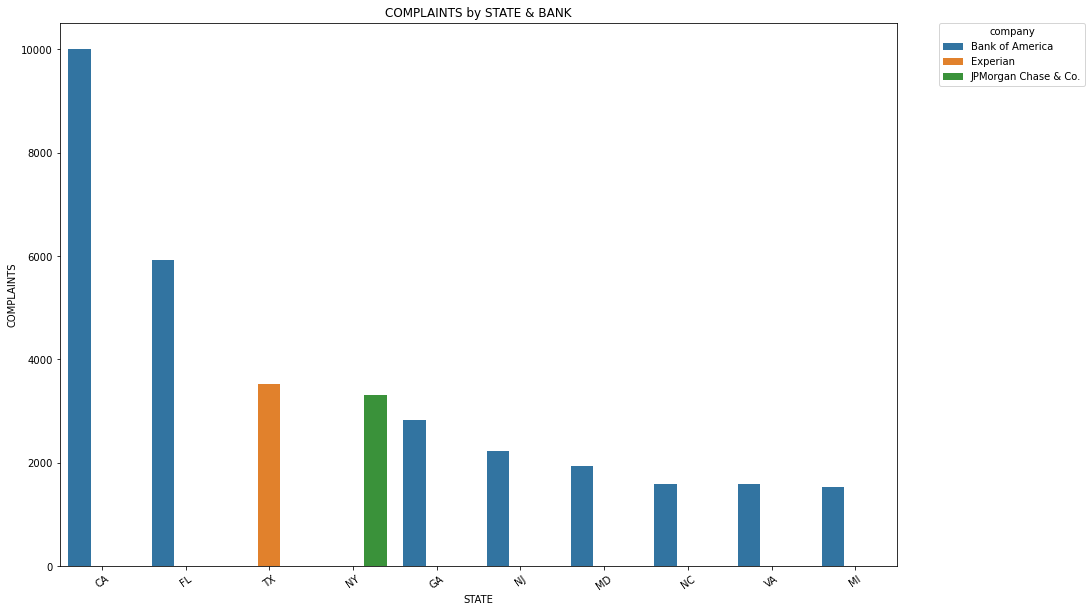

In [ ]:
#visualisation
plt.figure(figsize = (15, 10))

sns.barplot(data = state_bank, y = 'issue', x = 'state', hue = 'company', palette = 'tab10')
#state_bank.plot(kind = 'bar', y = 'issue', x = 'state', stacked = True, figsize = (15, 10))
plt.legend(title = 'company', bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.title('COMPLAINTS by STATE & BANK')
plt.xlabel('STATE')
plt.ylabel('COMPLAINTS')
plt.xticks(rotation = 35);

> Bank of America had been recieving lots of complaints from 7 states out of the 10 states with the highest revieved.
#### Why is Bank of America receiving so much complaints?

In [ ]:
#subset of data with just bank of america
boa = df_clean[df_clean['company'] == 'Bank of America']
boa.head(10)

,complaint_id,date_received,company,product,issue,state,zipcode,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_year,loan/not_loan
7,511116,2013-08-30,Bank of America,Bank account or service,Deposits and withdrawals,IL,60660,Referral,2013-09-04,Closed with explanation,Yes,No,2013,Not Loan related
8,511091,2013-08-30,Bank of America,Bank account or service,Deposits and withdrawals,GA,30016,Referral,2013-09-04,Closed with explanation,Yes,No,2013,Not Loan related
12,511090,2013-08-30,Bank of America,Mortgage,Credit decision / Underwriting,TX,75023,Web,2013-09-03,Closed with explanation,Yes,No,2013,Not Loan related
14,521353,2013-09-10,Bank of America,Debt collection,Communication tactics,GA,30132,Web,2013-09-14,Closed with explanation,Yes,No,2013,Not Loan related
20,530624,2013-09-17,Bank of America,Credit card,Billing disputes,TN,37874,Phone,2013-11-04,Closed with explanation,Yes,Yes,2013,Not Loan related
27,521360,2013-09-10,Bank of America,Credit card,Rewards,NJ,8512,Web,2013-09-19,Closed with explanation,Yes,No,2013,Not Loan related
31,521364,2013-09-10,Bank of America,Bank account or service,Deposits and withdrawals,TX,78704,Web,2013-09-11,Closed with explanation,Yes,No,2013,Not Loan related
67,530654,2013-09-17,Bank of America,Mortgage,"Loan modification,collection,foreclosure",GA,30701,Web,2013-09-18,Closed with explanation,Yes,No,2013,Loan related
78,530663,2013-09-17,Bank of America,Mortgage,"Loan modification,collection,foreclosure",IL,60561,Web,2013-09-18,Closed with explanation,Yes,No,2013,Loan related
82,521395,2013-09-10,Bank of America,Mortgage,"Application, originator, mortgage broker",CA,90605,Web,2013-09-10,Closed with explanation,Yes,No,2013,Not Loan related


> How many complaints do they recieve on each Products?

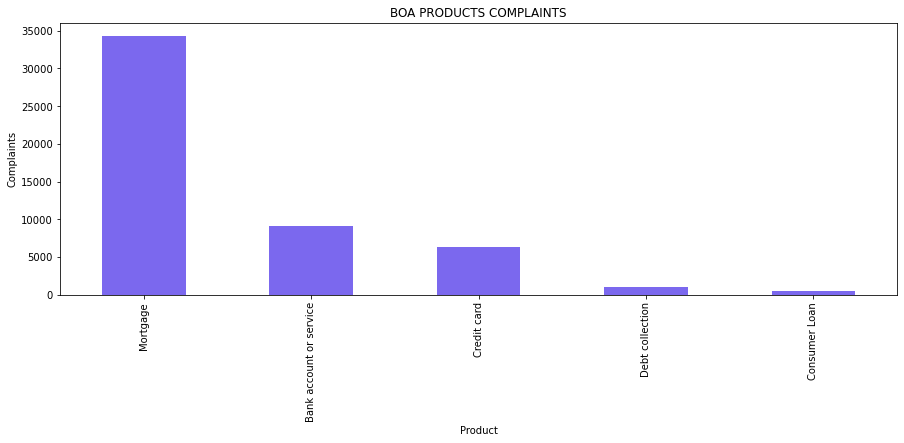

In [ ]:
#visualisation
boa['product'].value_counts().head().plot(kind = 'bar', color = color, figsize = (15, 5), legend = False)
plt.title('BOA PRODUCTS COMPLAINTS')
plt.ylabel('Complaints')
plt.xlabel('Product');

> They recieved alot of  complaints with their Mortgage, and it seems they are loan related as well.  
* How many of this complaints are related to loans issues?

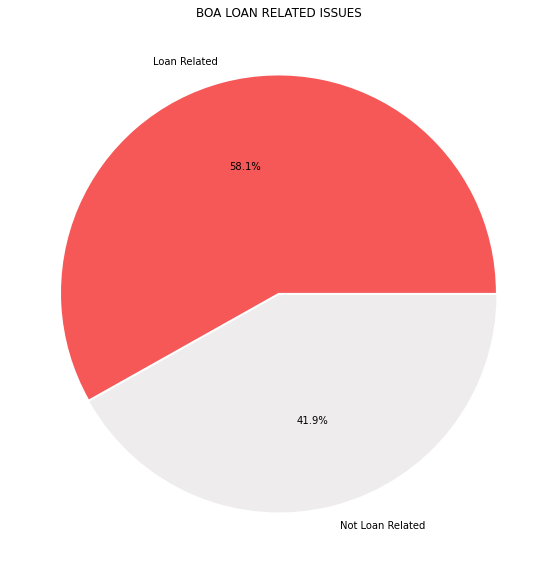

In [ ]:
#visualisation
explode = (0.01, 0)
boa['loan/not_loan'].value_counts().plot.pie(y = 'issue', explode = explode , autopct = '%1.1f%%', ylabel = '',
                       labels = ['Loan Related','Not Loan Related'], colors = ['#F65858', '#EEECEC'], figsize = (15, 10))
plt.title("BOA LOAN RELATED ISSUES");

> It's like I expected, majority of the issues had something to do with loans, probably loan collection, repayment. But then
* What was their response to this complaints?

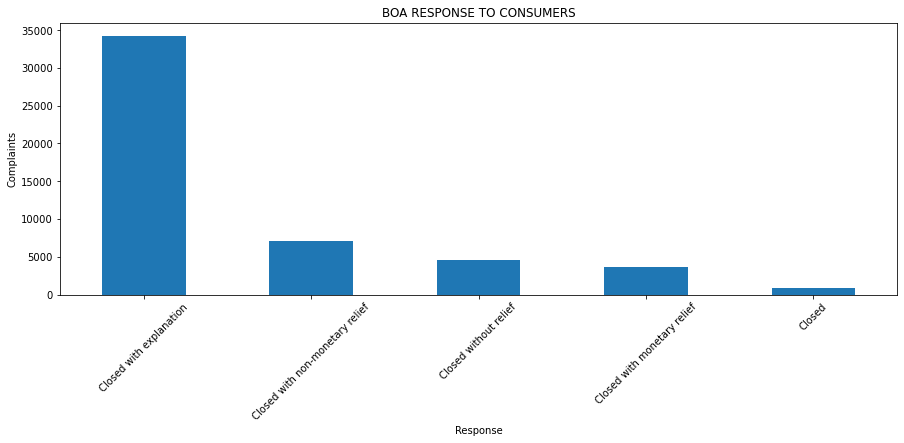

In [ ]:
#visualisation
boa['company_response_to_consumer'].value_counts().head().plot(kind = 'bar', figsize = (15, 5), legend = False)
plt.title('BOA RESPONSE TO CONSUMERS')
plt.ylabel('Complaints')
plt.xlabel('Response')
plt.xticks(rotation = 45);

> They were closing lots of this coplaints by explanation to their consumers, But;
* Did consumers still raise a dispute & How fast was their response?

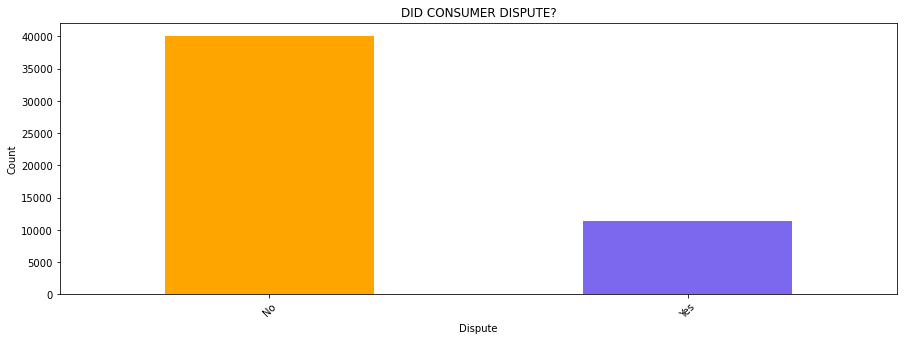

In [ ]:
#visualisation
boa['consumer_disputed?'].value_counts().head().plot(kind = 'bar', color = ['orange', color], figsize = (15, 5), legend = False)
plt.title('DID CONSUMER DISPUTE?')
plt.ylabel('Count')
plt.xlabel('Dispute')
plt.xticks(rotation = 45);

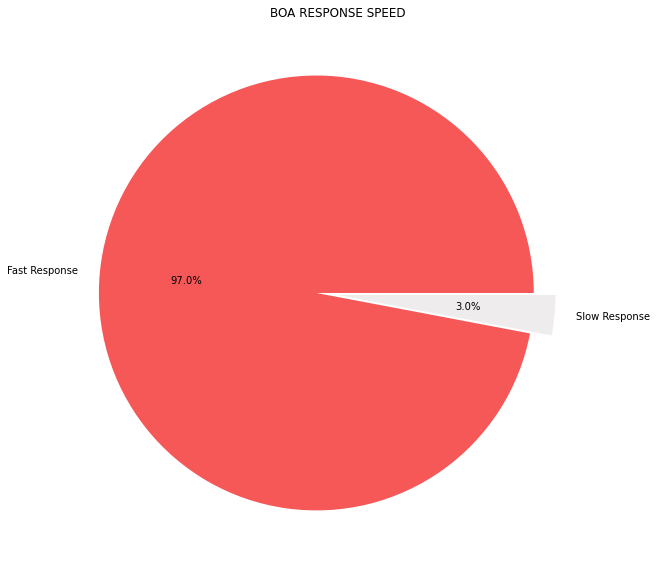

In [ ]:
#visualisation

explode = (0.1, 0)
boa['timely_response'].value_counts().plot.pie(explode = explode , autopct = '%1.1f%%', ylabel = '',
                       labels = ['Fast Response','Slow Response'], colors = ['#F65858', '#EEECEC'], figsize = (15, 10))
plt.title("BOA RESPONSE SPEED");

> From this we can see that they dished out swift response to consumers complaints and disputes and consumers were very satisfied by their explanations.

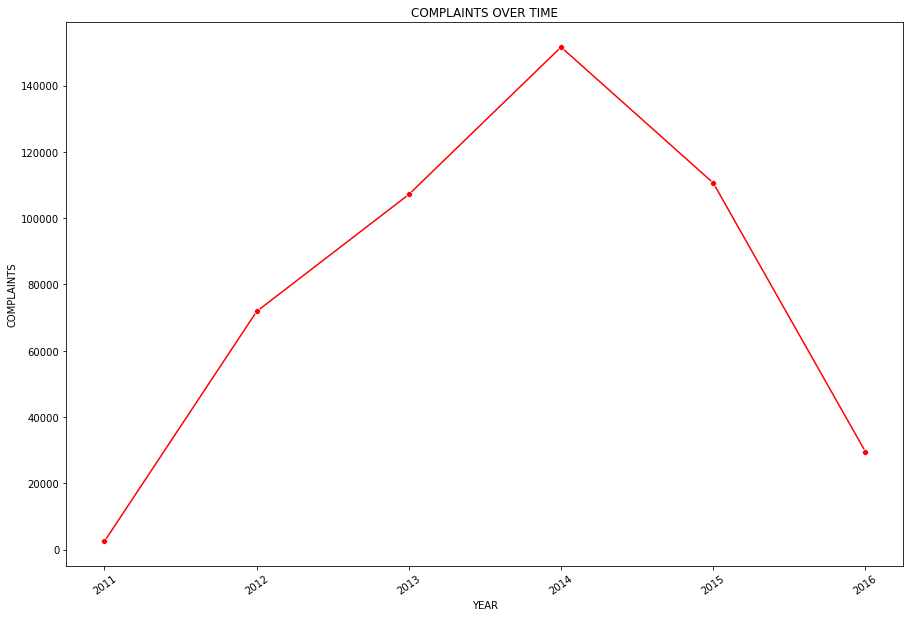

In [ ]:
#visualisation
plt.figure(figsize = (15, 10))
sns.lineplot(data = yearly_comp, x = 'complaint_year', y = 'complaint_id', marker = 'o', color = 'red')
plt.title('COMPLAINTS OVER TIME')
plt.xlabel('YEAR')
plt.ylabel('COMPLAINTS')
plt.xticks(rotation = 35);

> After digging into the data I found out;
* The product with the most complaints is **Mortgage**, but why;
* **Issues** with/related **Loan** are the cause for the high number of increasing complaints.
* Bank of America recorded the highest number of complaints & issues because consumers were having loan problems.
* **CA & FL** are the leading states with the most issues & complaints, but more data & further analysis should be carried out to know why.
> **Limitations::** There is not enough demographic data on the states to determine why most of the loan issues came from **CA & FL**

> AFter Investigating the reason for increase in complaints, I want to know why the suddent decline from 2015.
### What is the cause of decline in complaints from 2015?
* Did the companies drop the product causing alot of complaints(**Mortage**)?
* If NO, was it improved, did the complaints reduce significantly?
* Did the companies improve their products(**Mortgage** especially)?Did they


#### Did the companies drop the product causing alot of complaints(Mortage)?

In [ ]:
#checking the products for 2015


prod_comp_yr = df_clean.groupby(['complaint_year', 'product']).size().reset_index(name = 'complaint_count').sort_values(
                by = ['complaint_year', 'complaint_count'], ascending=[True,False])
prod_comp_yr = prod_comp_yr[prod_comp_yr['complaint_year'] >= 2014]

prod_comp_yr

,complaint_year,product,complaint_count
23,2014,Mortgage,42716
21,2014,Debt collection,38831
20,2014,Credit reporting,28912
17,2014,Bank account or service,14393
19,2014,Credit card,13867
18,2014,Consumer Loan,5412
27,2014,Student loan,4247
25,2014,Payday loan,1677
22,2014,Money transfers,1124
26,2014,Prepaid card,331


> The same products are still in service so why the decline in complaints, 
### Are the products improved, did the complaints reduce significantly?

In [ ]:
#subset of dataset with complaints of each product yearly
#products
prod_comp_yr_2015 = prod_comp_yr[prod_comp_yr['complaint_year'] >= 2014]

prod_comp_yr_2015

,complaint_year,product,complaint_count
23,2014,Mortgage,42716
21,2014,Debt collection,38831
20,2014,Credit reporting,28912
17,2014,Bank account or service,14393
19,2014,Credit card,13867
18,2014,Consumer Loan,5412
27,2014,Student loan,4247
25,2014,Payday loan,1677
22,2014,Money transfers,1124
26,2014,Prepaid card,331


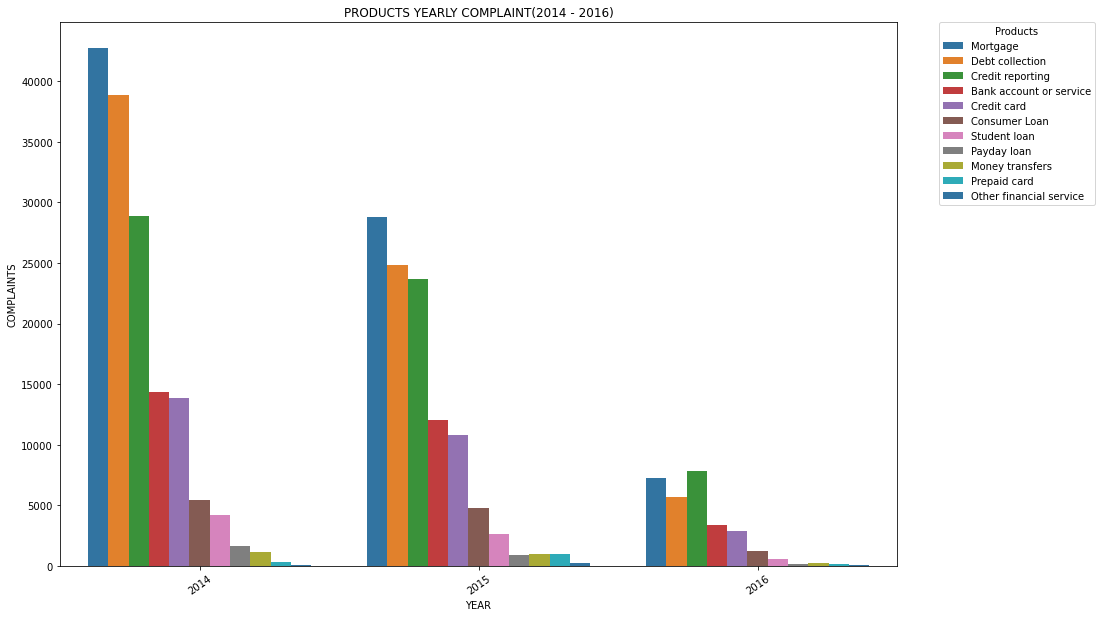

In [ ]:
plt.figure(figsize = (15, 10))

sns.barplot(data = prod_comp_yr_2015, x = 'complaint_year', y = 'complaint_count', hue = 'product', palette = 'tab10')
plt.legend(title = 'Products', bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.title('PRODUCTS YEARLY COMPLAINT(2014 - 2016)')
plt.xlabel('YEAR')
plt.ylabel('COMPLAINTS')
plt.xticks(rotation = 35);

> Thers's been a significant decrease in the number of complaints on the product **Mortgage**; It's safe to assume they're improving on it. But am intrested in knowing if the Loan related issues decreased as well.
#### Did Loan related issues decrease as well?

In [ ]:
mortgage_2015 = mortgage.copy()
mortgage_2015 = mortgage_2015[mortgage_2015['complaint_year'] >= 2014]
mortgage_2015

,complaint_id,product,issue,complaint_year,loan/not_loan
4414,662650,Mortgage,Other,2014,Not Loan related
5812,744269,Mortgage,Settlement process and costs,2014,Not Loan related
11691,653461,Mortgage,Other,2014,Not Loan related
11720,654314,Mortgage,"Loan modification,collection,foreclosure",2014,Loan related
11751,654321,Mortgage,"Loan modification,collection,foreclosure",2014,Loan related
...,...,...,...,...,...
553078,1769158,Mortgage,"Loan servicing, payments, escrow account",2016,Loan related
553083,1776992,Mortgage,"Loan modification,collection,foreclosure",2016,Loan related
553087,1866715,Mortgage,"Loan servicing, payments, escrow account",2016,Loan related
553093,1859306,Mortgage,"Loan modification,collection,foreclosure",2016,Loan related


In [ ]:
mortgage_2015 = mortgage_2015.groupby(['complaint_year', 'loan/not_loan'])['issue'].count().reset_index()
mortgage_2015

,complaint_year,loan/not_loan,issue
0,2014,Loan related,37030
1,2014,Not Loan related,5686
2,2015,Loan related,24122
3,2015,Not Loan related,4642
4,2016,Loan related,6106
5,2016,Not Loan related,1176


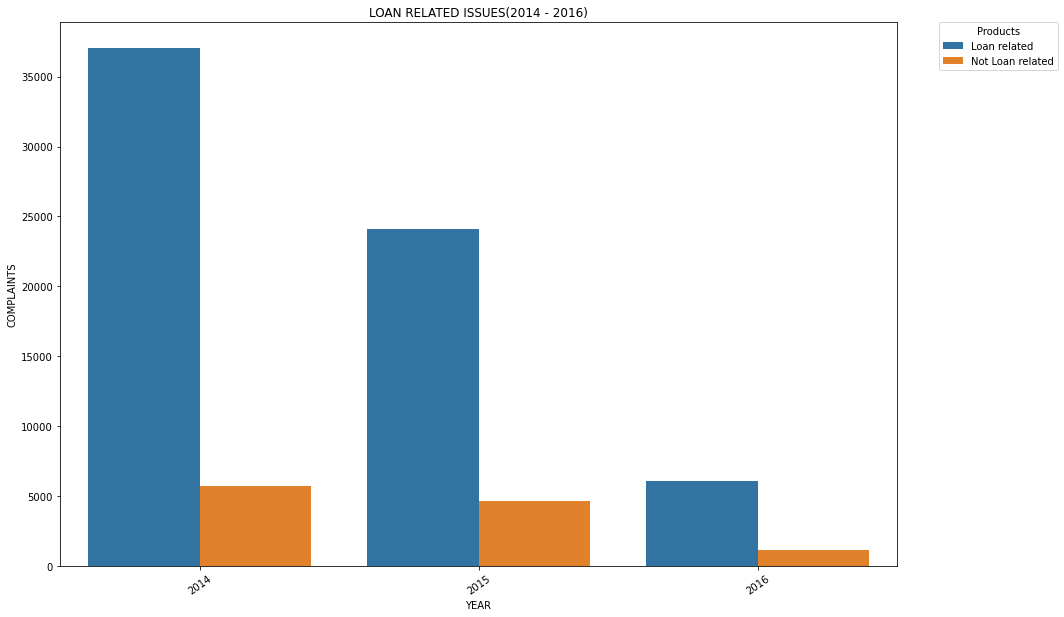

In [ ]:
plt.figure(figsize = (15, 10))

sns.barplot(data = mortgage_2015, x = 'complaint_year', y = 'issue', hue = 'loan/not_loan', palette = 'tab10')
plt.legend(title = 'Products', bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.title('LOAN RELATED ISSUES(2014 - 2016)')
plt.xlabel('YEAR')
plt.ylabel('COMPLAINTS')
plt.xticks(rotation = 35);

> I can see a steady amd significant decline in the Loan related issues as well so I can say there's been an improvement on their products.

## Conclusion & Reccomendation

After cleaning the data and doing a **Root Cause Analysis using the 5 why's**, I found out the Root cause of the high number of complaints in 2014 & the sudden decline from 2015;

> **Initial Problem: Why the high number of complaints in 2014?**
* The product with the most complaints is **Mortgage**,
>but why?;
* **Issues** with/related **Loan** are the cause for the high number of increasing complaints,
>why so much issues related to loans?.
* Bank of America recorded the highest number of complaints & issues,
>Why did Bank of America have such high nuber of complaints?.
* **This is because consumers are having troubles with the whole loan process ie(loan repayment, loan collection, loan modification), because they're likely taking this loans to pay their mortgage**.   
> But then why the sudden increase or need for this;
* **CA & FL** are the leading states with the most issues & complaints so it's safe to assume the cost of living for this locations increased, but further analysis should be carried out to know exactly why.
> **Limitations::** There is not enough demographic data on the states to determine why most of the loan issues came from **CA & FL**
> AFter Investigating the reason for increase in complaints, I wanted to know why the suddent decline from 2015.
### What is the cause of decline in complaints from 2015?
* Did the companies drop the product causing alot of complaints(**Mortage**)?
> The same products are still in service so why the decline in complaints so NO mortgage was not dropped from the products, 
* Since the same products are still available, were they improved, did the complaints reduce significantly?
> Thers's been a significant decrease in the number of complaints on the product **Mortgage**; It's safe to assume they're improving on it. But am intrested in knowing if the Loan related issues decreased as well.
#### Did Loan related issues decrease as well?
* Did the companies improve their products(**Mortgage** especially)?Did they
 > I can see a steady amd significant decline in the Loan related issues as well so I can say there's been an improvement on their products.

#### So the question of why was there so much complaints, was narrowed down to too many loan issues were raised is CA & FL for most Bank of America and Wells Fargo, so I will suggest the following;
* More data should be collected to understand the reason why so much loan related issues were coming from those states(**CA & FL**).
* Companies should improve on their products especially **Mortgage & Debts Collection**
* Companies should re-evaluate the way they hand **Loan** related issues as well.